data: https://huggingface.co/nlp/viewer/?dataset=clue&config=afqmc

In [1]:
pip install datasets


In [2]:
pip install transformers

# **Import Modules**

In [3]:
import random
import torch
import torch.nn as nn
import numpy as np
from datasets import load_dataset
from scipy import stats
import seaborn as sns
from transformers import AutoTokenizer, BertForTokenClassification, BertTokenizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
from torch.utils.data import TensorDataset
import torch.nn.functional as F

# **Set Some Parameters**

In [29]:
BATCH_SIZE = 8
EPOCHS = 30
UNIQUE_LABELS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
MAX_LENGTH = 40
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Define Classes and Functions**

In [5]:
class DataSet:
  """load dataset"""
  def __init__(self, dataset_name='clue', sub_name='tnews', train=True):
    if train:
      dataset = load_dataset(dataset_name, sub_name ,split='train')
    else:
      dataset = load_dataset(dataset_name, sub_name, split='validation')
    self.dataset_name = dataset_name
    self.sub_name = sub_name
    self.dataset = dataset
  
  def __len__(self):
    return len(self.dataset)

  def get_data(self, n):
    # randomly select n instances from the dataset
    indices = random.sample(range(0, len(self.dataset)), n)
    return self.dataset.select(indices)




class TokenizeVectorizeData:
  """Tokenize text by BertTokenizer of certain bert base model; one hot encode labels."""
  def __init__(self, data, unique_labels= UNIQUE_LABELS, tokenizer=BertTokenizer.from_pretrained('bert-base-chinese')):

    # one-hot encode labels
    def one_hot_encode_label(s):
      encoded_label = [0]*len(unique_labels)
      for i in range(0,len(unique_labels)):
        if s == unique_labels[i]:
          encoded_label[i] = 1
        else:
          encoded_label[i] = 0
      return encoded_label

    data = data.map(lambda x: {'labels': one_hot_encode_label(x['label'])})
    length = len(data)

    def encode(example):
      return tokenizer(example['sentence'], truncation=True, padding='max_length',max_length=MAX_LENGTH)
  
    tokenized_data = data.map(encode, batched=True)

    #tokenized_data.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    #tokenized_data.set_format(type='torch', columns=['input_ids', 'labels'])  
    x = torch.tensor(tokenized_data['input_ids'])
    y = torch.tensor(tokenized_data['labels'])
    data = TensorDataset(x,y)

    features = {'input_ids': tokenized_data['input_ids']}
    labels = {'labels':tokenized_data['labels']}

    self.data = data
    self.features = features
    self.unique_labels = unique_labels
    self.labels = labels
    self.length = length
  
  def __len__(self):
    return self.length

  def data_loader(self, batch_size=BATCH_SIZE):
    # data generator
    data_loader = torch.utils.data.DataLoader(self.data, batch_size=batch_size)
    return data_loader



#class BertMultiClass(torch.nn.Module):
    #def __init__(self, dropout=0.2):
        #super(BertMultiClass, self).__init__()
        #self.bert = BertForTokenClassification.from_pretrained('bert-base-chinese',
                                                                 #num_labels=30,
                                                                 #output_attentions=False,
                                                                 #output_hidden_states=False)
        #self.linear = nn.Linear(MAX_LENGTH*30, len(UNIQUE_LABELS))
        #self.softmax = F.Softmax()
    
    #def forward(self, inputs):
        #_, pooled_output = self.bert(inputs, utput_all=False)
        #linear_output = self.linear(dropout_output)
        #probas = self.softmax(linear_output)
        #return probas



def tune_bert(train_loader, base_bert_name='bert-base-chinese',freeze=False):
  """Fine tune base bert model. """
  #model = BertMultiClass()
  model = BertForTokenClassification.from_pretrained(base_bert_name,
                                                     num_labels=len(UNIQUE_LABELS),
                                                     output_attentions=False,
                                                     output_hidden_states=False)

  ## freeze model if freeze=True
  if freeze:
    for param in model.base_model.base_model.parameters():
      param.requires_grad = False


  model.train().to(DEVICE)
  optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(EPOCHS):
    train_loss = 0
    for i, batch in enumerate(tqdm(train_loader)):
      #batch = {k: v.to(DEVICE) for k, v in batch.items()}
      if batch[0].size()[0] != BATCH_SIZE:
            continue
      input_ids = batch[0].to(DEVICE)
      labels = batch[1].to(DEVICE).view(BATCH_SIZE,len(UNIQUE_LABELS))
      inputs = {'input_ids': input_ids}         
      outputs = model(**inputs)
      loss = loss_fn(outputs[0], labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
    average_train_loss = train_loss / len(train_loader)
    print("{}/{} average training loss:{}".format(epoch+1, EPOCHS, average_train_loss))

  return model



def predict(model, val_loader):
  loss_fn = nn.CrossEntropyLoss()
  model.eval()
  val_loss = 0
  pred_labels = []
  true_labels = []
  for i, batch in enumerate(tqdm(val_loader)):
    #batch = {k:v.to(DEVICE) for k, v in batch.items()}
    input_ids = batch[0].to(DEVICE)
    label = batch[1].to(DEVICE).view(1,len(UNIQUE_LABELS))
    input = {'input_ids':input_ids}
    with torch.no_grad():
      output = model(**input)
    loss = loss_fn(output[0],label)

    loss = loss.detach().cpu()
    val_loss += loss.item()

    output = output[0].detach().cpu().numpy()
    predictions = np.concatenate(output, axis=0)
    predictions = np.sum(predictions, axis=0)
    pred_label = np.argmax(predictions)
    pred_labels.append(pred_label)

    true_lab = np.argmax(label.detach().cpu().numpy())
    true_labels.append(true_lab)

  val_loss_average = val_loss/len(val_loader)
    
            
  return val_loss_average, pred_labels, true_labels



# **Load Training and Validation Datasets**

In [6]:
train = DataSet(train=True)
val = DataSet(train=False)

Reusing dataset clue (/root/.cache/huggingface/datasets/clue/tnews/1.0.0/dfaf73ec4bf2b67968c7a9ac5b08bfad1c037f4b768cf76580d9b0db2322b457)
Reusing dataset clue (/root/.cache/huggingface/datasets/clue/tnews/1.0.0/dfaf73ec4bf2b67968c7a9ac5b08bfad1c037f4b768cf76580d9b0db2322b457)


# **Inspect the Data**

In [7]:
train.dataset[0]

{'idx': 0,
 'label': 7,
 'sentence': '上课时学生手机响个不停，老师一怒之下把手机摔了，家长拿发票让老师赔，大家怎么看待这种事？'}

In [8]:
train.dataset.features

{'idx': Value(dtype='int32', id=None),
 'label': ClassLabel(num_classes=15, names=['100', '101', '102', '103', '104', '106', '107', '108', '109', '110', '112', '113', '114', '115', '116'], names_file=None, id=None),
 'sentence': Value(dtype='string', id=None)}

In [9]:
# number of words in each sentence
lens = [len(s) for s in train.dataset['sentence']]

In [10]:
# statistic data of sentence lengths
stats.describe(lens)

DescribeResult(nobs=53360, minmax=(2, 145), mean=22.13124062968516, variance=53.43405839446607, skewness=0.1538816973869811, kurtosis=1.3791815845163802)

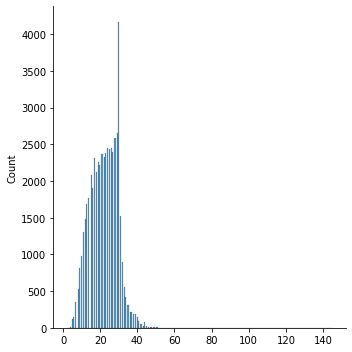

In [11]:
# plot the distribution of sentence lengths (number of word in sentences)
sns.displot(lens)

# **Select Data**
* select training sets with 1000, 5000 and 500 instances from training section
* select evaluation set with 2000 instances from validation section

In [12]:
# get 1000 data from the training object
train_1 = train.get_data(1000)

In [13]:
# get 5000 data from the training object
train_5 = train.get_data(5000)
train_5[0]

{'idx': 8822, 'label': 4, 'sentence': '废除伊核协议只会推升油价？没那么简单！'}

In [14]:
# get 500 data from the training object
train_500 = train.get_data(500)

In [15]:
train_500[0]

{'idx': 43389, 'label': 6, 'sentence': '考C1科目三难吗？'}

In [16]:
# generate evaluation data object and get 2000 data from it
val_set = val.get_data(2000)

# **Tokenize Data**

In [17]:
# generate TokenizeVectorizeData object with train_1
tokenized_data = TokenizeVectorizeData(train_1)

In [18]:
# get the data loader of train_1
train_1_loader = tokenized_data.data_loader()

In [19]:
# size of input batch
s = next(iter(train_1_loader))
s[0].size()

torch.Size([8, 40])

In [20]:
# size of label batch
s[1].size()

torch.Size([8, 15])

In [21]:
len(train_1_loader)

125

In [22]:
# get the data loader of 5000 tokenized data
train_5_loader = TokenizeVectorizeData(train_5).data_loader()

In [23]:
# get the data loader of 500 tokenized data
train_500_loader = TokenizeVectorizeData(train_500).data_loader()

In [24]:
# generate evaluation tokenized object and get the evaluation data loader
val_loader = TokenizeVectorizeData(val_set).data_loader(batch_size=1)


# **Tune Models and Predict on Evaluation Set**
__________________________________________________

**1. fine tune on training data with 1000 instances, then predict on evaluation set**

In [30]:
model = tune_bert(train_1_loader)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

1/30 average training loss:1.0053358471393585


  2%|▏         | 2/125 [00:00<00:11, 10.40it/s]

2/30 average training loss:0.3064642004966736


  1%|          | 1/125 [00:00<00:12,  9.71it/s]

3/30 average training loss:0.2789027247428894


  2%|▏         | 2/125 [00:00<00:11, 10.51it/s]

4/30 average training loss:0.26632919859886167


  2%|▏         | 2/125 [00:00<00:11, 10.60it/s]

5/30 average training loss:0.25540507197380063


  2%|▏         | 2/125 [00:00<00:11, 10.48it/s]

6/30 average training loss:0.23939110052585602


  2%|▏         | 2/125 [00:00<00:11, 10.66it/s]

7/30 average training loss:0.21669107031822205


  2%|▏         | 2/125 [00:00<00:11, 10.45it/s]

8/30 average training loss:0.18148827224969863


  2%|▏         | 2/125 [00:00<00:11, 10.60it/s]

9/30 average training loss:0.1432168674468994


  2%|▏         | 2/125 [00:00<00:11, 10.37it/s]

10/30 average training loss:0.10956776744127274


  2%|▏         | 2/125 [00:00<00:11, 10.50it/s]

11/30 average training loss:0.08857711559534073


  2%|▏         | 2/125 [00:00<00:11, 10.55it/s]

12/30 average training loss:0.06070501418411732


  2%|▏         | 2/125 [00:00<00:11, 10.53it/s]

13/30 average training loss:0.04372208262979984


  2%|▏         | 2/125 [00:00<00:11, 10.32it/s]

14/30 average training loss:0.03349317127466202


  2%|▏         | 2/125 [00:00<00:11, 10.58it/s]

15/30 average training loss:0.026251929379999636


  2%|▏         | 2/125 [00:00<00:11, 10.61it/s]

16/30 average training loss:0.020581132918596267


  2%|▏         | 2/125 [00:00<00:11, 10.34it/s]

17/30 average training loss:0.01644975919276476


  2%|▏         | 2/125 [00:00<00:11, 10.45it/s]

18/30 average training loss:0.012935802668333054


  2%|▏         | 2/125 [00:00<00:11, 10.53it/s]

19/30 average training loss:0.010600418854504823


  2%|▏         | 2/125 [00:00<00:11, 10.60it/s]

20/30 average training loss:0.009954690914601088


  2%|▏         | 2/125 [00:00<00:11, 10.56it/s]

21/30 average training loss:0.008411448094993829


  2%|▏         | 2/125 [00:00<00:11, 10.58it/s]

22/30 average training loss:0.0075450755171477795


  2%|▏         | 2/125 [00:00<00:11, 10.45it/s]

23/30 average training loss:0.006489798590540886


  2%|▏         | 2/125 [00:00<00:11, 10.62it/s]

24/30 average training loss:0.005625354785472154


  2%|▏         | 2/125 [00:00<00:11, 10.35it/s]

25/30 average training loss:0.006821565767750144


  2%|▏         | 2/125 [00:00<00:11, 10.42it/s]

26/30 average training loss:0.005150415057316423


  2%|▏         | 2/125 [00:00<00:11, 10.56it/s]

27/30 average training loss:0.004909265149384737


  2%|▏         | 2/125 [00:00<00:11, 10.60it/s]

28/30 average training loss:0.004783735128119588


  2%|▏         | 2/125 [00:00<00:11, 10.49it/s]

29/30 average training loss:0.00391288347914815


100%|██████████| 125/125 [00:12<00:00, 10.39it/s]

30/30 average training loss:0.006687239477410912


In [33]:
# save model into file
#model.save_pretrained('./my_bert_model_1/')
#model.from_pretrained('./my_bert_model_1/')
_, pred_1, true_1 = predict(model, val_loader)

100%|██████████| 2000/2000 [00:26<00:00, 74.10it/s]


**2. fine tune on training data with 5000 instances, then predict on evaluation set**

In [36]:
model = tune_bert(train_5_loader)
# save model into file
#model.save_pretrained('./my_bert_model_5/')

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

1/30 average training loss:0.4024808708190918


  0%|          | 2/625 [00:00<00:58, 10.57it/s]

2/30 average training loss:0.16955968803763388


  0%|          | 2/625 [00:00<00:59, 10.53it/s]

3/30 average training loss:0.13267139629125596


  0%|          | 2/625 [00:00<00:58, 10.59it/s]

4/30 average training loss:0.10934997216165065


  0%|          | 2/625 [00:00<00:58, 10.59it/s]

5/30 average training loss:0.0854212127149105


  0%|          | 2/625 [00:00<00:58, 10.68it/s]

6/30 average training loss:0.0658063058257103


  0%|          | 2/625 [00:00<00:59, 10.55it/s]

7/30 average training loss:0.04828281753510237


  0%|          | 2/625 [00:00<00:58, 10.62it/s]

8/30 average training loss:0.035757697556912896


  0%|          | 2/625 [00:00<00:59, 10.51it/s]

9/30 average training loss:0.026449784395098687


  0%|          | 2/625 [00:00<00:58, 10.66it/s]

10/30 average training loss:0.019817432144284247


  0%|          | 2/625 [00:00<00:58, 10.60it/s]

11/30 average training loss:0.015149748443625868


  0%|          | 2/625 [00:00<00:58, 10.59it/s]

12/30 average training loss:0.014153134209290147


  0%|          | 2/625 [00:00<00:58, 10.62it/s]

13/30 average training loss:0.011441344924829901


  0%|          | 2/625 [00:00<00:59, 10.54it/s]

14/30 average training loss:0.011270215142052621


  0%|          | 2/625 [00:00<00:58, 10.62it/s]

15/30 average training loss:0.00815507178902626


  0%|          | 2/625 [00:00<00:58, 10.61it/s]

16/30 average training loss:0.007764265893958509


  0%|          | 2/625 [00:00<00:59, 10.39it/s]

17/30 average training loss:0.007057367002218962


  0%|          | 2/625 [00:00<00:59, 10.54it/s]

18/30 average training loss:0.0070990436335559935


  0%|          | 2/625 [00:00<00:59, 10.52it/s]

19/30 average training loss:0.005559171818103641


  0%|          | 2/625 [00:00<00:58, 10.63it/s]

20/30 average training loss:0.005064392319787294


  0%|          | 2/625 [00:00<00:58, 10.57it/s]

21/30 average training loss:0.00635894887894392


  0%|          | 2/625 [00:00<00:58, 10.60it/s]

22/30 average training loss:0.0058757508623879405


  0%|          | 2/625 [00:00<00:58, 10.58it/s]

23/30 average training loss:0.0067032935212831945


  0%|          | 2/625 [00:00<00:59, 10.50it/s]

24/30 average training loss:0.003780298661021516


  0%|          | 2/625 [00:00<00:59, 10.49it/s]

25/30 average training loss:0.005057450222270563


  0%|          | 2/625 [00:00<00:58, 10.57it/s]

26/30 average training loss:0.0040184309643693265


  0%|          | 2/625 [00:00<00:59, 10.48it/s]

27/30 average training loss:0.005708657340565696


  0%|          | 2/625 [00:00<00:59, 10.51it/s]

28/30 average training loss:0.005042643847083673


  0%|          | 2/625 [00:00<00:58, 10.63it/s]

29/30 average training loss:0.004444403155893087


100%|██████████| 625/625 [00:59<00:00, 10.44it/s]

30/30 average training loss:0.0057164668546058235


In [37]:
# model = model.from_pretrained('./my_bert_model_5/')
_, pred_5, true_5 = predict(model, val_loader)

100%|██████████| 2000/2000 [00:26<00:00, 75.99it/s]


**3. freeze embeddings, only fine tune classification layer, then predict on evaluation set**

In [39]:
model = tune_bert(train_1_loader, freeze=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

1/30 average training loss:3.584045347213745


  4%|▍         | 5/125 [00:00<00:02, 48.86it/s]

2/30 average training loss:3.2843204765319824


  4%|▍         | 5/125 [00:00<00:02, 48.15it/s]

3/30 average training loss:2.9964986057281493


  4%|▍         | 5/125 [00:00<00:02, 49.75it/s]

4/30 average training loss:2.7318019008636476


  4%|▍         | 5/125 [00:00<00:02, 48.54it/s]

5/30 average training loss:2.4887756443023683


  4%|▍         | 5/125 [00:00<00:02, 47.65it/s]

6/30 average training loss:2.2466318645477297


  4%|▍         | 5/125 [00:00<00:02, 49.04it/s]

7/30 average training loss:2.0351792306900025


  4%|▍         | 5/125 [00:00<00:02, 47.08it/s]

8/30 average training loss:1.8501198644638062


  4%|▍         | 5/125 [00:00<00:02, 48.41it/s]

9/30 average training loss:1.6651106233596802


  4%|▍         | 5/125 [00:00<00:02, 48.35it/s]

10/30 average training loss:1.517538459777832


  4%|▍         | 5/125 [00:00<00:02, 49.19it/s]

11/30 average training loss:1.3717975025177003


  4%|▍         | 5/125 [00:00<00:02, 49.01it/s]

12/30 average training loss:1.244044111251831


  4%|▍         | 5/125 [00:00<00:02, 46.63it/s]

13/30 average training loss:1.1403363847732544


  4%|▍         | 5/125 [00:00<00:02, 48.00it/s]

14/30 average training loss:1.0463845200538635


  5%|▍         | 6/125 [00:00<00:02, 49.95it/s]

15/30 average training loss:0.9678135290145874


  5%|▍         | 6/125 [00:00<00:02, 50.50it/s]

16/30 average training loss:0.8998875207901001


  4%|▍         | 5/125 [00:00<00:02, 47.50it/s]

17/30 average training loss:0.8314438514709472


  4%|▍         | 5/125 [00:00<00:02, 48.35it/s]

18/30 average training loss:0.768419713973999


  4%|▍         | 5/125 [00:00<00:02, 48.57it/s]

19/30 average training loss:0.7211679000854492


  4%|▍         | 5/125 [00:00<00:02, 49.00it/s]

20/30 average training loss:0.6752461171150208


  5%|▍         | 6/125 [00:00<00:02, 50.77it/s]

21/30 average training loss:0.6382753920555114


  4%|▍         | 5/125 [00:00<00:02, 49.82it/s]

22/30 average training loss:0.6165427222251892


  4%|▍         | 5/125 [00:00<00:02, 49.08it/s]

23/30 average training loss:0.5737719390392303


  5%|▍         | 6/125 [00:00<00:02, 50.48it/s]

24/30 average training loss:0.5609141647815704


  5%|▍         | 6/125 [00:00<00:02, 50.57it/s]

25/30 average training loss:0.5240157856941223


  5%|▍         | 6/125 [00:00<00:02, 50.41it/s]

26/30 average training loss:0.5048052287101745


  4%|▍         | 5/125 [00:00<00:02, 48.41it/s]

27/30 average training loss:0.4911052250862122


  5%|▍         | 6/125 [00:00<00:02, 50.18it/s]

28/30 average training loss:0.4668358714580536


  4%|▍         | 5/125 [00:00<00:02, 49.27it/s]

29/30 average training loss:0.4680954353809357


100%|██████████| 125/125 [00:02<00:00, 48.96it/s]

30/30 average training loss:0.4605636250972748


In [40]:
_, freeze_pred_1, freeze_true_1 = predict(model, val_loader)

100%|██████████| 2000/2000 [00:26<00:00, 74.90it/s]


**4. freeze embeddings, only fine tune classification layer on data 5000, then predict on evaluation set**

In [41]:
model = tune_bert(train_5_loader, freeze=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

1/30 average training loss:2.9589225635528567


  1%|          | 5/625 [00:00<00:12, 48.20it/s]

2/30 average training loss:1.8392208421707152


  1%|          | 5/625 [00:00<00:12, 49.11it/s]

3/30 average training loss:1.1555208187103272


  1%|          | 5/625 [00:00<00:12, 49.79it/s]

4/30 average training loss:0.7706067575454711


  1%|          | 6/625 [00:00<00:12, 50.41it/s]

5/30 average training loss:0.5807131973743439


  1%|          | 5/625 [00:00<00:12, 49.18it/s]

6/30 average training loss:0.47507005610466


  1%|          | 5/625 [00:00<00:12, 47.87it/s]

7/30 average training loss:0.4298268422603607


  1%|          | 5/625 [00:00<00:12, 49.16it/s]

8/30 average training loss:0.3951047055244446


  1%|          | 5/625 [00:00<00:12, 49.47it/s]

9/30 average training loss:0.3721165002822876


  1%|          | 6/625 [00:00<00:12, 50.50it/s]

10/30 average training loss:0.36490138988494875


  1%|          | 5/625 [00:00<00:12, 48.41it/s]

11/30 average training loss:0.35440631101131437


  1%|          | 5/625 [00:00<00:12, 48.76it/s]

12/30 average training loss:0.3471994005680084


  1%|          | 5/625 [00:00<00:12, 48.67it/s]

13/30 average training loss:0.3497863041877747


  1%|          | 6/625 [00:00<00:12, 50.39it/s]

14/30 average training loss:0.33345543866157534


  1%|          | 6/625 [00:00<00:12, 50.28it/s]

15/30 average training loss:0.34310885875225067


  1%|          | 5/625 [00:00<00:12, 48.25it/s]

16/30 average training loss:0.3261730016231537


  1%|          | 6/625 [00:00<00:12, 50.32it/s]

17/30 average training loss:0.33092341957092286


  1%|          | 5/625 [00:00<00:12, 48.65it/s]

18/30 average training loss:0.3206296767950058


  1%|          | 5/625 [00:00<00:12, 48.86it/s]

19/30 average training loss:0.3200558058977127


  1%|          | 5/625 [00:00<00:12, 49.72it/s]

20/30 average training loss:0.32669079999923706


  1%|          | 6/625 [00:00<00:12, 50.15it/s]

21/30 average training loss:0.3212948991060257


  1%|          | 5/625 [00:00<00:13, 46.92it/s]

22/30 average training loss:0.32134385221004486


  1%|          | 5/625 [00:00<00:12, 48.70it/s]

23/30 average training loss:0.3093295656681061


  1%|          | 5/625 [00:00<00:12, 48.50it/s]

24/30 average training loss:0.31702528369426725


  1%|          | 5/625 [00:00<00:12, 48.78it/s]

25/30 average training loss:0.3088952362537384


  1%|          | 5/625 [00:00<00:12, 48.76it/s]

26/30 average training loss:0.3050144343137741


  1%|          | 6/625 [00:00<00:12, 50.13it/s]

27/30 average training loss:0.30981719727516177


  1%|          | 5/625 [00:00<00:12, 48.44it/s]

28/30 average training loss:0.30905081274509427


  1%|          | 5/625 [00:00<00:12, 48.26it/s]

29/30 average training loss:0.30700214762687683


100%|██████████| 625/625 [00:12<00:00, 48.44it/s]

30/30 average training loss:0.3032854223251343


In [42]:
_, freeze_pred_5, freeze_true_5 = predict(model, val_loader)

100%|██████████| 2000/2000 [00:27<00:00, 73.57it/s]


**5. tune on 500 sentences, then predict on evaluation set**

In [43]:
model = tune_bert(train_500_loader)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-c

1/30 average training loss:1.5012678608061776


  3%|▎         | 2/63 [00:00<00:05, 10.24it/s]

2/30 average training loss:0.3535818216346559


  3%|▎         | 2/63 [00:00<00:05, 10.40it/s]

3/30 average training loss:0.3018324834013742


  3%|▎         | 2/63 [00:00<00:05, 10.51it/s]

4/30 average training loss:0.2844000827698481


  3%|▎         | 2/63 [00:00<00:05, 10.27it/s]

5/30 average training loss:0.2735825725018032


  3%|▎         | 2/63 [00:00<00:05, 10.43it/s]

6/30 average training loss:0.26501686752788606


  3%|▎         | 2/63 [00:00<00:05, 10.58it/s]

7/30 average training loss:0.25835200410986703


  3%|▎         | 2/63 [00:00<00:05, 10.56it/s]

8/30 average training loss:0.24854644163260384


  3%|▎         | 2/63 [00:00<00:05, 10.62it/s]

9/30 average training loss:0.2389975455072191


  3%|▎         | 2/63 [00:00<00:05, 10.37it/s]

10/30 average training loss:0.22970936411903017


  3%|▎         | 2/63 [00:00<00:05, 10.58it/s]

11/30 average training loss:0.20678286869374532


  3%|▎         | 2/63 [00:00<00:05, 10.58it/s]

12/30 average training loss:0.1887224976505552


  3%|▎         | 2/63 [00:00<00:05, 10.52it/s]

13/30 average training loss:0.17287983851773397


  3%|▎         | 2/63 [00:00<00:05, 10.54it/s]

14/30 average training loss:0.1543933063272446


  3%|▎         | 2/63 [00:00<00:05, 10.59it/s]

15/30 average training loss:0.1406406429078844


  3%|▎         | 2/63 [00:00<00:05, 10.56it/s]

16/30 average training loss:0.12636871009118975


  3%|▎         | 2/63 [00:00<00:05, 10.37it/s]

17/30 average training loss:0.11068320735579446


  3%|▎         | 2/63 [00:00<00:05, 10.50it/s]

18/30 average training loss:0.09801889749036895


  3%|▎         | 2/63 [00:00<00:05, 10.65it/s]

19/30 average training loss:0.08647993366633143


  3%|▎         | 2/63 [00:00<00:05, 10.29it/s]

20/30 average training loss:0.07284603185123867


  3%|▎         | 2/63 [00:00<00:05, 10.35it/s]

21/30 average training loss:0.06290625715776095


  3%|▎         | 2/63 [00:00<00:05, 10.62it/s]

22/30 average training loss:0.05608868850247255


  3%|▎         | 2/63 [00:00<00:05, 10.66it/s]

23/30 average training loss:0.05007529439079383


  3%|▎         | 2/63 [00:00<00:05, 10.59it/s]

24/30 average training loss:0.0427713223570396


  3%|▎         | 2/63 [00:00<00:05, 10.58it/s]

25/30 average training loss:0.03695381355900613


  3%|▎         | 2/63 [00:00<00:05, 10.55it/s]

26/30 average training loss:0.032675932058029704


  3%|▎         | 2/63 [00:00<00:05, 10.65it/s]

27/30 average training loss:0.028826909524107738


  3%|▎         | 2/63 [00:00<00:05, 10.58it/s]

28/30 average training loss:0.026421768295149955


  3%|▎         | 2/63 [00:00<00:05, 10.61it/s]

29/30 average training loss:0.021499768860401617


100%|██████████| 63/63 [00:05<00:00, 10.61it/s]

30/30 average training loss:0.019447927377999774


In [44]:
_, pred_500, true_500 = predict(model, val_loader)

100%|██████████| 2000/2000 [00:26<00:00, 75.27it/s]


# **Macro and Micro f1 score**
__________________________________________________
**1. model trained on 1000 sentences**

In [35]:
# macro f score
print("1. fine tuned model on data 1000 ")
macro_f1 = f1_score(true_1,pred_1,average='macro')
# micro f score = accuracy
micro_f1 = f1_score(true_1, pred_1, average='micro')
print('macro f1:{},  micro f1: {}'.format(macro_f1, micro_f1))

1. fine tuned model on data 1000 
macro f1:0.42836667278135143,  micro f1: 0.474


In [34]:
# classification report
report = classification_report(true_1, pred_1)
print(report)

              precision    recall  f1-score   support

           0       0.23      0.12      0.16        41
           1       0.50      0.43      0.46       147
           2       0.63      0.56      0.60       199
           3       0.73      0.64      0.68       135
           4       0.35      0.60      0.44       202
           5       0.66      0.38      0.48        76
           6       0.41      0.67      0.51       159
           7       0.32      0.55      0.40       124
           8       0.59      0.31      0.41       228
           9       0.56      0.43      0.48       140
          10       0.54      0.31      0.39       145
          11       0.45      0.39      0.42       168
          12       0.00      0.00      0.00         9
          13       0.52      0.42      0.46        98
          14       0.49      0.57      0.53       129

    accuracy                           0.47      2000
   macro avg       0.46      0.43      0.43      2000
weighted avg       0.51   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**2. model trained on 5000 sentences**

**Note: As the micro f1 is equal to accuracy for multi-class classification, I don't compute micro f1 manually as I did above. From the classification report, micro and macro f1 and etc. are all clear.**

In [38]:
report = classification_report(true_5, pred_5)
print(report)

              precision    recall  f1-score   support

           0       0.54      0.32      0.40        41
           1       0.44      0.53      0.48       147
           2       0.45      0.70      0.55       199
           3       0.55      0.67      0.60       135
           4       0.58      0.22      0.32       202
           5       0.51      0.47      0.49        76
           6       0.67      0.57      0.62       159
           7       0.72      0.25      0.37       124
           8       0.57      0.54      0.55       228
           9       0.63      0.38      0.47       140
          10       0.52      0.32      0.39       145
          11       0.60      0.35      0.44       168
          12       0.00      0.00      0.00         9
          13       0.19      0.74      0.30        98
          14       0.54      0.53      0.54       129

    accuracy                           0.47      2000
   macro avg       0.50      0.44      0.44      2000
weighted avg       0.54   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**3. freeze embeddings, model tuned on 1000 instancs**

In [45]:
report = classification_report(freeze_true_1, freeze_pred_1)
print(report)

              precision    recall  f1-score   support

           0       0.02      0.24      0.03        41
           1       0.00      0.00      0.00       147
           2       0.00      0.00      0.00       199
           3       0.00      0.00      0.00       135
           4       0.00      0.00      0.00       202
           5       0.00      0.00      0.00        76
           6       0.00      0.00      0.00       159
           7       0.00      0.00      0.00       124
           8       0.07      0.38      0.12       228
           9       0.00      0.00      0.00       140
          10       0.00      0.00      0.00       145
          11       0.00      0.00      0.00       168
          12       0.00      0.00      0.00         9
          13       0.05      0.05      0.05        98
          14       0.00      0.00      0.00       129

    accuracy                           0.05      2000
   macro avg       0.01      0.05      0.01      2000
weighted avg       0.01   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**4. freeze embeddings, model tuned on 5000 instances**


In [46]:
report = classification_report(freeze_true_5, freeze_pred_5)
print(report)

              precision    recall  f1-score   support

           0       0.02      0.41      0.03        41
           1       0.00      0.00      0.00       147
           2       0.02      0.02      0.02       199
           3       0.00      0.00      0.00       135
           4       0.00      0.00      0.00       202
           5       0.00      0.00      0.00        76
           6       0.01      0.02      0.01       159
           7       0.00      0.00      0.00       124
           8       0.00      0.00      0.00       228
           9       0.02      0.02      0.02       140
          10       0.00      0.00      0.00       145
          11       0.00      0.00      0.00       168
          12       0.00      0.00      0.00         9
          13       0.01      0.02      0.01        98
          14       0.07      0.02      0.03       129

    accuracy                           0.01      2000
   macro avg       0.01      0.03      0.01      2000
weighted avg       0.01   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**5. model tuned on 500 instances**

In [47]:
report = classification_report(true_500, pred_500)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        41
           1       0.00      0.00      0.00       147
           2       0.00      0.00      0.00       199
           3       0.08      0.99      0.16       135
           4       0.27      0.38      0.31       202
           5       0.00      0.00      0.00        76
           6       0.86      0.19      0.31       159
           7       0.50      0.01      0.02       124
           8       0.78      0.17      0.28       228
           9       0.64      0.11      0.19       140
          10       0.00      0.00      0.00       145
          11       0.00      0.00      0.00       168
          12       0.00      0.00      0.00         9
          13       0.50      0.01      0.02        98
          14       0.38      0.06      0.11       129

    accuracy                           0.15      2000
   macro avg       0.27      0.13      0.09      2000
weighted avg       0.31   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
